In [1]:
# Get important libraries for this class.
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import csv
import random
#--------------------------------------------------------
from tensorflow.python.ops import control_flow_ops
from IPython.display import clear_output
from urllib.request import urlopen
from scipy.spatial.distance import squareform, pdist
from sklearn.preprocessing import normalize
from numpy import linalg as LA
from scipy.cluster.vq import kmeans, vq
from sklearn.metrics import normalized_mutual_info_score
from tqdm import tqdm
#--------------------------------------------------------
warnings.filterwarnings('ignore')

In [2]:
class similarity_func:
    def get_k_nn_column(self, k):
        def f(vector):
            v = np.zeros(len(vector))
            indices = np.argsort(vector)
            v[indices[0:k]] = vector[indices][0:k]
            return v
        return f
    def get_k_nn_column_rev(self, k):
        def f(vector):
            v = np.zeros(len(vector))
            rev_indices = np.argsort(vector)[::-1]
            v[rev_indices[0:k]] = vector[rev_indices][0:k]
            return v
        return f
    def sigmoidal_normalize(self, v):
        v = (v - min(v)) / (max(v) - min(v))
        return v

In [3]:
class Cosine_Similarity(similarity_func):
    def __init__(self, Normalize: object) -> object:
        self.Normalize = Normalize
    def get_matrix(self, data):
        if self.Normalize:
            data = normalize(data, axis=0)
        m = squareform(pdist(data, 'cosine'))
        m = np.dot(LA.matrix_power(np.diag(np.sum(m, 0)), -1), m)
        if self.Normalize:
            m = np.apply_along_axis(self.sigmoidal_normalize, 1, m)
        np.fill_diagonal(m, 0.)
        return m

In [4]:
class Nearest_Neighbors_Similarity(similarity_func):
    def __init__(self, Normalize: object) -> object:
        self.Normalize = Normalize
    def get_matrix(self, data):
        if self.Normalize:
            data = normalize(data, axis=0)
        from sklearn.neighbors import kneighbors_graph
        n_neighbors = max(int(data.shape[0] / 10), 1)
        m = kneighbors_graph(data, n_neighbors, mode='connectivity', include_self=True)
        m = m.toarray()
        if self.Normalize:
            m = np.apply_along_axis(self.sigmoidal_normalize, 1, m)
        np.fill_diagonal(m, 0.)
        return m

In [5]:
class Similarity_Dataset_Iterator():
    def __init__(self, data, labels, similarity):
        self.data = data
        self.labels = labels
        self.matrix = similarity.get_matrix(data)
        self.data_size = self.matrix.shape[0]
        self.current_index = 0
    def next_batch(self, n):
        return (self.matrix.transpose(), self.labels)
    def whole_dataset(self):
        return (self.matrix.transpose(), self.labels)

In [6]:
def read_wine_data(similarity):
    with open('../Autoencoder_vs_Spectral_on_Wine/Wine_Dataset/wine_data.csv') as csvfile:
        csvreader = csv.reader(csvfile)
        next(csvreader, None) # skip header
        dataset = list(csvreader)
    random.shuffle(dataset)
    datatrain = dataset[:int(len(dataset))]
    data = [data[:13] for data in datatrain]
    labels = [data[13] for data in datatrain]   
    return Similarity_Dataset_Iterator(data, labels, similarity)

In [7]:
# Call Nearest_Neighbors_Similarity or Cosine_Similarity as similarity dataset.
data_set = read_wine_data(Cosine_Similarity(Normalize=True))
data_set_NN = read_wine_data(Nearest_Neighbors_Similarity(Normalize=True))

In [8]:
n_input = 178 # number of input data.
n_code = '16' # the number of output value or embedding data codes.
# The autoencoder hidden layers
n_encoder_hidden_1 = 128
n_encoder_hidden_2 = 64
n_encoder_hidden_3 = 32
# Here we have low dimensional embedding to reconstruct the input.
n_decoder_hidden_1 = 32
n_decoder_hidden_2 = 64
n_decoder_hidden_3 = 128

In [9]:
def encoder(x, n_code, phase_train):    
    with tf.variable_scope("encoder"):        
        with tf.variable_scope("hidden_1"):
            hidden_1 = layer(x, [n_input, n_encoder_hidden_1], [n_encoder_hidden_1], phase_train)
        with tf.variable_scope("hidden_2"):
            hidden_2 = layer(hidden_1, [n_encoder_hidden_1, n_encoder_hidden_2], [n_encoder_hidden_2], phase_train)
        with tf.variable_scope("hidden_3"):
            hidden_3 = layer(hidden_2, [n_encoder_hidden_2, n_encoder_hidden_3], [n_encoder_hidden_3], phase_train)
        with tf.variable_scope("code"):
            code = layer(hidden_3, [n_encoder_hidden_3, n_code], [n_code], phase_train)
    return code

In [10]:
def decoder(code, n_code, phase_train):
    with tf.variable_scope("decoder"):
        with tf.variable_scope("hidden_1"):
            hidden_1 = layer(code, [n_code, n_decoder_hidden_1], [n_decoder_hidden_1], phase_train)
        with tf.variable_scope("hidden_2"):
            hidden_2 = layer(hidden_1, [n_decoder_hidden_1, n_decoder_hidden_2], [n_decoder_hidden_2], phase_train)
        with tf.variable_scope("hidden_3"):
            hidden_3 = layer(hidden_2, [n_decoder_hidden_2, n_decoder_hidden_3], [n_decoder_hidden_3], phase_train)
        with tf.variable_scope("output"):
            output = layer(hidden_3, [n_decoder_hidden_3, n_input], [n_input], phase_train)
    return output

In [11]:
def layer_batch_norm(x, n_out, phase_train):
    beta_init = tf.constant_initializer(value=0.0, dtype=tf.float32)
    gamma_init = tf.constant_initializer(value=1.0, dtype=tf.float32)
    beta = tf.get_variable("beta", [n_out], initializer=beta_init)
    gamma = tf.get_variable("gamma", [n_out], initializer=gamma_init)
    batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    ema_apply_op = ema.apply([batch_mean, batch_var])
    ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
    def mean_var_with_update():
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
    mean, var = control_flow_ops.cond(phase_train, mean_var_with_update, lambda: (ema_mean, ema_var))
    reshaped_x = tf.reshape(x, [-1, 1, 1, n_out])
    normed = tf.nn.batch_norm_with_global_normalization(reshaped_x, mean, var, beta, gamma, 1e-3, True)
    return tf.reshape(normed, [-1, n_out])

In [12]:
def layer(input, weight_shape, bias_shape, phase_train):
    weight_init = tf.random_normal_initializer(stddev=(1.0 / weight_shape[0]) ** 0.5)
    bias_init = tf.constant_initializer(value=0)
    W = tf.get_variable("W", weight_shape, initializer=weight_init)
    b = tf.get_variable("b", bias_shape, initializer=bias_init)
    logits = tf.matmul(input, W) + b
    return tf.nn.sigmoid(layer_batch_norm(logits, weight_shape[1], phase_train))

In [13]:
def loss(output, x):
    with tf.variable_scope("training"):
        l2 = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(output, x)), 1))
        train_loss = tf.reduce_mean(l2)
        train_summary_op = tf.summary.scalar("train_cost", train_loss)
        return train_loss, train_summary_op

In [14]:
def training(cost, global_step):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.99, epsilon=1e-08, use_locking=False, name='Adam')
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op

In [15]:
# Parameters
learning_rate = 0.001 # The learning rate, it should be a floating point value.
training_epochs = 3000 # The time priod of train on the model.
n_backpropagation = 300 # after 300 epochs, getting embedding data and run the KMeans on it. 

In [16]:
with tf.Graph().as_default():    
    with tf.variable_scope("autoencoder_model"):                
        x = tf.placeholder("float", [None, n_input])   
        phase_train = tf.placeholder(tf.bool)
        code = encoder(x, int(n_code), phase_train)
        output = decoder(code, int(n_code), phase_train)
        cost, train_summary_op = loss(output, x)
        global_step = tf.Variable(0, name='global_step', trainable=False)
        train_op = training(cost, global_step)
        summary_op = tf.summary.merge_all()
        sess = tf.Session()
        init_op = tf.global_variables_initializer()
        sess.run(init_op)

In [17]:
# Training cycle
results=[]
loss_cost=[]
steps=[]
batch_size = data_set.next_batch(1)[0].shape
for epoch in tqdm(range(training_epochs+1)):
    # Fit training using batch data in backpropagation.
    _, new_cost, train_summary = sess.run([train_op, cost, train_summary_op],
                                          feed_dict={x: data_set.next_batch(batch_size)[0], phase_train: True}) 
    if epoch % n_backpropagation == 0 or epoch == training_epochs:
        ae_codes = sess.run(code, feed_dict={x: data_set.next_batch(1)[0], phase_train: True})
        # Running K-Means on data.
        centroids, _ = kmeans(ae_codes,3)
        idx, _ = vq(ae_codes, centroids)
        ae_nmi = normalized_mutual_info_score(data_set.next_batch(1)[1], idx)
        results.append(ae_nmi)
        steps.append(epoch)
        loss_cost.append(new_cost)
        print("NMI Score for AE is: {:0.2f} and new cost is: {:0.2f} in {:d} step. ".format(ae_nmi,new_cost, epoch))

  0%|                                                                                         | 0/3001 [00:00<?, ?it/s]

NMI Score for AE is: 0.75 and new cost is: 4.44 in 0 step. 


 10%|███████▊                                                                       | 298/3001 [00:09<01:25, 31.60it/s]

NMI Score for AE is: 0.81 and new cost is: 0.95 in 300 step. 


 20%|███████████████▋                                                               | 598/3001 [00:18<01:13, 32.79it/s]

NMI Score for AE is: 0.80 and new cost is: 0.48 in 600 step. 


 30%|███████████████████████▋                                                       | 898/3001 [00:26<01:03, 33.29it/s]

NMI Score for AE is: 0.82 and new cost is: 0.26 in 900 step. 


 40%|███████████████████████████████▏                                              | 1198/3001 [00:35<00:53, 33.56it/s]

NMI Score for AE is: 0.85 and new cost is: 0.20 in 1200 step. 


 50%|██████████████████████████████████████▉                                       | 1498/3001 [00:44<00:44, 33.65it/s]

NMI Score for AE is: 0.85 and new cost is: 0.16 in 1500 step. 


 60%|██████████████████████████████████████████████▋                               | 1798/3001 [00:53<00:35, 33.86it/s]

NMI Score for AE is: 0.85 and new cost is: 0.14 in 1800 step. 


 70%|██████████████████████████████████████████████████████▌                       | 2098/3001 [01:01<00:26, 33.91it/s]

NMI Score for AE is: 0.87 and new cost is: 0.12 in 2100 step. 


 80%|██████████████████████████████████████████████████████████████▎               | 2399/3001 [01:10<00:17, 33.88it/s]

NMI Score for AE is: 0.87 and new cost is: 0.11 in 2400 step. 


 90%|██████████████████████████████████████████████████████████████████████        | 2698/3001 [01:19<00:08, 33.73it/s]

NMI Score for AE is: 0.87 and new cost is: 0.11 in 2700 step. 


100%|█████████████████████████████████████████████████████████████████████████████▉| 2998/3001 [01:28<00:00, 33.76it/s]

NMI Score for AE is: 0.85 and new cost is: 0.10 in 3000 step. 


100%|██████████████████████████████████████████████████████████████████████████████| 3001/3001 [01:28<00:00, 33.75it/s]


In [18]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.errorbar(steps, results, label='Autoencoder on Normalized Cosine Similarity', color='r')
plt.ylabel('NMI')
plt.grid()
plt.title(('NMI of Autoencoder Clustring after {:d} steps.').format(training_epochs))
plt.legend(loc='best')
plt.subplot(1, 2, 2)
plt.errorbar(steps, loss_cost, label='Autoencoder Cost Function', color='b')
plt.grid()
plt.title(('Cost Function Value after {:d} steps.').format(training_epochs))
plt.legend(loc='best')

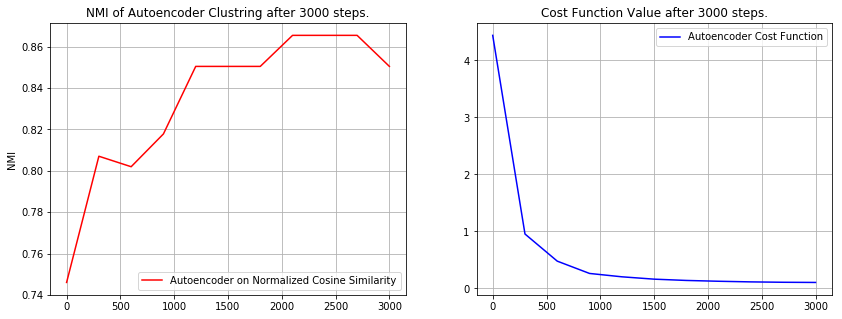

In [19]:
plt.show()

In [20]:
def spectral_clustering(X, n_cluster):
    D_ = np.matrix(np.diag(np.sum(X,0)))
    D_ = D_**(-1)
    L = np.dot(np.dot(D_, X),D_)
    eigenvectors = np.linalg.eig(L)[1]
    X = np.real(eigenvectors[:,0:n_cluster])
    X = normalize(X,axis=1)
    return k_means_(X,3), X

In [21]:
def k_means_(X, n_cluster):
    kmeans_centroids,_ =  kmeans(X,n_cluster)
    kmeans_, _ = vq(X, kmeans_centroids)
    return kmeans_

In [22]:
indx, spec_code= spectral_clustering(data_set.next_batch(1)[0],3)
spectral_nmi = (normalized_mutual_info_score(data_set.next_batch(1)[1], indx))
print(("Spectral CS:    {:0.2f}".format(spectral_nmi)))
#------------------------------------------------------------------------------------------------------
indx_NN, spec_code_NN= spectral_clustering(data_set_NN.next_batch(1)[0],3)
spectral_nmi_NN = (normalized_mutual_info_score(data_set_NN.next_batch(1)[1], indx_NN))
print(("Spectral NN:    {:0.2f}".format(spectral_nmi_NN)))
#------------------------------------------------------------------------------------------------------
k_means_indx = k_means_(data_set.next_batch(1)[0],3)
k_means_nmi_ = (normalized_mutual_info_score(data_set.next_batch(1)[1], k_means_indx))
print(("KMeans CS:      {:0.2f}".format(k_means_nmi_)))
#------------------------------------------------------------------------------------------------------
k_means_indx_NN = k_means_(data_set_NN.next_batch(1)[0],3)
k_means_nmi_NN = (normalized_mutual_info_score(data_set_NN.next_batch(1)[1], k_means_indx_NN))
print(("KMeans NN:      {:0.2f}".format(k_means_nmi_NN)))
#------------------------------------------------------------------------------------------------------
print("Autoencoder:    {:0.2f}".format(ae_nmi))

Spectral CS:    0.75
Spectral NN:    0.82
KMeans CS:      0.56
KMeans NN:      0.53
Autoencoder:    0.85


In [23]:
origin_label = np.array(data_set.next_batch(1)[1]).astype(int)
colors = [('r', '1'),('b', '2'),('g', '3')]
plt.figure(figsize=(14, 10))
for num in range(3):
    plt.subplot(2,2,1)
    plt.scatter([spec_code[:,0][i] for i in range(len(origin_label)) if origin_label[i] == num],
                [spec_code[:,1][i] for i in range(len(origin_label)) if origin_label[i] == num],
                99, label=str(num), color = colors[num][0], marker=colors[num][1])        
    plt.title("Spectral Embbeding")
    plt.legend() 
    plt.subplot(2,2,2)
    plt.scatter([ae_codes[:,0][i] for i in range(len(origin_label)) if origin_label[i] == num],
                [ae_codes[:,1][i] for i in range(len(origin_label)) if origin_label[i] == num],
                99, label=str(num), color = colors[num][0], marker=colors[num][1])        
    plt.title("Autoencoder Embbeding")
    plt.legend()
    plt.subplot(2,2,3)
    plt.scatter([spec_code[:,0][i] for i in range(len(indx)) if indx[i] == num],
                [spec_code[:,1][i] for i in range(len(indx)) if indx[i] == num],
                99, label=str(num), color = colors[num][0], marker=colors[num][1])        
    plt.title("Spectral Clustering")
    plt.legend() 
    
    plt.subplot(2,2,4)
    plt.scatter([ae_codes[:,0][i] for i in range(len(idx)) if idx[i] == num],
                [ae_codes[:,1][i] for i in range(len(idx)) if idx[i] == num],
                99, label=str(num), color = colors[num][0], marker=colors[num][1])        
    plt.title("Autoencoder Clustering")
    plt.legend()

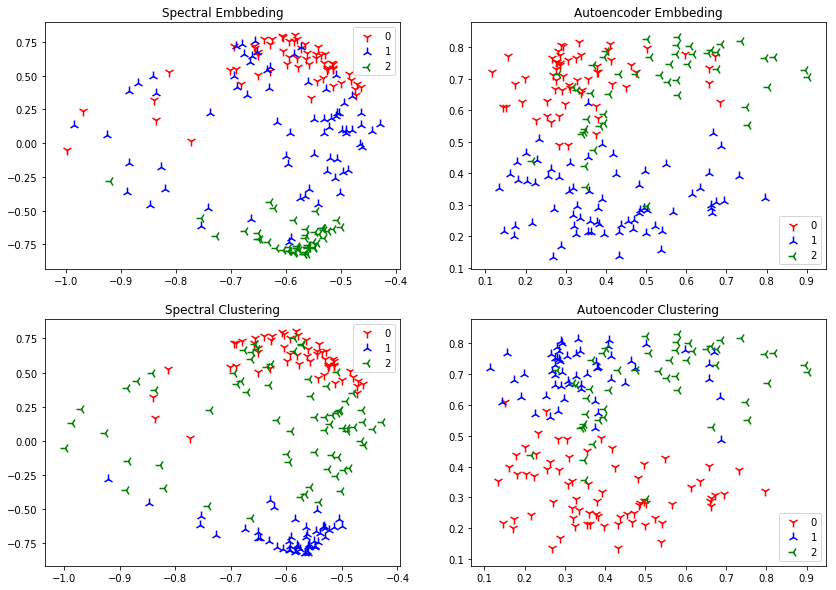

In [24]:
plt.show()